# 2018_climate4R_example2
This worked example contains the full code that reproduces the 2nd example of the paper "climate4R: An R-based Framework for Climate Data Access, Post-processing and Bias Correction" (Sec. 6 of the manuscript). The main section is divided in additional subsections to help with the understanding of the different code chunks. All operations hereinafter are performed with the core packages of climate4R, excepting (1) package installation and (2) the creation of color palettes, for which packages `devtools` and `RColorBrewer` are used respectively:

(1) Package loading


In [1]:
options(java.parameters = "-Xmx8000m")
library(loadeR)
library(transformeR)
library(visualizeR)
library(downscaleR)
library(climate4R.climdex)

Loading required package: rJava
Loading required package: loadeR.java
Java version 1.8x amd64 by Oracle Corporation detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
loadeR version 1.4.8 (2018-09-23) is loaded
Please use 'citation("loadeR")' to cite this package.
transformeR version 1.4.7 (2018-10-20) is loaded
Development version may have an unexpected behaviour
Please see 'citation("transformeR")' to cite this package.
Loading required package: sm
Warning message:
“no DISPLAY variable so Tk is not available”Package 'sm', version 2.2-5.6: type help(sm) for summary information
visualizeR version 1.3.0 (2018-10-17) is loaded

Attaching package: ‘visualizeR’

The following objects are masked from ‘package:transformeR’:

    clim2sgdf, map.lines, map.stippling

Loading required package: deepnet
Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

downscaleR version 3.0.4 (2018-09-23) is loaded
P

(2) Brewer palettes:

In [2]:
library(RColorBrewer)
colstx <- rev(brewer.pal(n = 9, "Spectral"))
colsindex <- rev(brewer.pal(n = 9, "RdYlBu"))
colsdelta <- brewer.pal(n = 9, "Reds")
colsbias <- brewer.pal(n = 9, "PiYG")
colssd <- brewer.pal(n = 9, "Blues")

***
NOTE: see also [2018_climate4R_example1.pdf](https://github.com/SantanderMetGroup/notebooks/blob/master/2018_climate4R_example1.pdf) for a better understanding of this document.

***

# Example 2: CORDEX Ensembles via the User Data Gateway

## Loading via the User Data Gateway

We define the domain of the Iberian Peninsula with the following bounding coordinates:


In [3]:
lon <- c(-10, 5)
lat <- c(36, 44)

The UDG service requires (free) [registration](http://www.meteo.unican.es/udg-wiki) to accept the data policies of the different data providers. Once a valid user name and password have been issued, the authentication must be done within the R session before data loading with function `loginUDG`:


In [53]:
loginUDG(username = "UDGusr", password = "UDGpswrd")

[2018-12-14 14:31:54] Setting credentials...
[2018-12-14 14:31:54] Success!
Go to <http://www.meteo.unican.es/udg-tap/home> for details on your authorized groups and datasets


If the data is to be loaded from the UDG, we can use function `UDG.datasets` to print the inventory of the available public and harmonized **UDG** datasets, where the name, type and url are specified (see Table 1 in the manuscript). Additionally, we can use the "name" (`UDG.datasets()["name"]`) of the desired dataset instead of passing the complete url to `loadGridData`. If this is the case, we do not need to create a dictionary, since the data is harmonized by default. Nevertheless, we still can use the complete url (`UDG.datasets()["url"]`) to access the data in its original form. 

For example, if we are interested in loading observations from the **E-OBS** dataset at 0.25 degrees resolution we can filter the names returned by `UDG.datasets` passing an appropriate pattern to the optional argument `pattern`:


In [5]:
models <- UDG.datasets(pattern = "E-OBS.*0.25")
eobs <- models$name

Object `eobs` contains the name of the dataset and is passed to `loadGridData` for loading maximum temperature using the standard name "tasmax" (and without using the dictionary argument, see [2018_climate4R_example1.pdf](https://github.com/SantanderMetGroup/notebooks/blob/master/2018_climate4R_example1.pdf)):


In [6]:
TX <- loadGridData(eobs,
                         var = "tasmax",
                         season = 1:12,
                         lonLim = lon,
                         latLim = lat,
                         years = 1971:2000)

NOTE: Accessing harmonized data from a public UDG dataset
[2018-12-14 12:50:11] Defining harmonization parameters for variable "tasmax"
[2018-12-14 12:50:11] Opening dataset...
[2018-12-14 12:50:11] The dataset was successfuly opened
[2018-12-14 12:50:11] Defining geo-location parameters
[2018-12-14 12:50:11] Defining time selection parameters
[2018-12-14 12:50:12] Retrieving data subset ...
[2018-12-14 12:50:31] Done


To load historical CORDEX data for the Iberian Peninsula we also filtered the names in `UDG.datasets()` with an appropriate pattern:


In [7]:
models <- UDG.datasets(pattern = "CORDEX-EUR44.*historical")
ensemble.h <- models$name[1:6]

Unlike the first example of the paper (see [2018_climate4R_example1.pdf](https://github.com/SantanderMetGroup/notebooks/blob/master/2018_climate4R_example1.pdf)), here we considered 6 regional climate models (RCMs) from EURO-CORDEX, thus, object `ensemble.h` contains 6 names. Everything can be loaded in a single step by combining function `loadGridData` with `lapply`:


In [8]:
TXh.list <- lapply(ensemble.h, function(x) 
                              loadGridData(dataset = x,
                              var = "tasmax",
                              season = 1:12,
                              lonLim = lon,
                              latLim = lat,
                              years = 1971:2000))

NOTE: Accessing harmonized data from a public UDG dataset
[2018-12-14 12:50:31] Defining harmonization parameters for variable "tasmax"
[2018-12-14 12:50:31] Opening dataset...
[2018-12-14 12:50:31] The dataset was successfuly opened
[2018-12-14 12:50:31] Defining geo-location parameters
[2018-12-14 12:50:31] Defining time selection parameters
[2018-12-14 12:50:31] Retrieving data subset ...
[2018-12-14 12:50:46] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2018-12-14 12:50:46] Defining harmonization parameters for variable "tasmax"
[2018-12-14 12:50:46] Opening dataset...
[2018-12-14 12:50:48] The dataset was successfuly opened
[2018-12-14 12:50:48] Defining geo-location parameters
[2018-12-14 12:50:48] Defining time selection parameters
[2018-12-14 12:50:48] Retrieving data subset ...
[2018-12-14 12:51:03] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2018-12-14 12:51:03] Defining harmonization parameters for variable "tasmax"
[2018-12-14 12:51:03

We repeat the operation for the RCP8.5 scenario:


In [9]:
ensemble.f <- UDG.datasets(pattern = "CORDEX-EUR44.*rcp85")$name[1:6]
TXf.list <- lapply(ensemble.f, function(x) 
                          loadGridData(dataset = x,
                          var = "tasmax",
                          season = 1:12,
                          lonLim = lon,
                          latLim = lat,
                          years = 2071:2100))

NOTE: Accessing harmonized data from a public UDG dataset
[2018-12-14 12:52:28] Defining harmonization parameters for variable "tasmax"
[2018-12-14 12:52:28] Opening dataset...
[2018-12-14 12:52:28] The dataset was successfuly opened
[2018-12-14 12:52:28] Defining geo-location parameters
[2018-12-14 12:52:28] Defining time selection parameters
[2018-12-14 12:52:28] Retrieving data subset ...
[2018-12-14 12:52:43] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2018-12-14 12:52:43] Defining harmonization parameters for variable "tasmax"
[2018-12-14 12:52:43] Opening dataset...
[2018-12-14 12:52:45] The dataset was successfuly opened
[2018-12-14 12:52:45] Defining geo-location parameters
[2018-12-14 12:52:45] Defining time selection parameters
[2018-12-14 12:52:45] Retrieving data subset ...
[2018-12-14 12:53:01] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2018-12-14 12:53:01] Defining harmonization parameters for variable "tasmax"
[2018-12-14 12:53:01

As a result, we obtain the following harmonized grids:

* `TX`: a single grid for E-OBS and reference period 1971-2000
* `TXh.list`: a list of 6 grids for the reference period 1971-2000 (historical scenario)
* `TXf.list`: a list of 6 grids for the future period 2071-2100 (RCP8.5 scenario).


## Working with multi-model ensembles

climate4R functionalities allow working with model ensembles through the `member` dimension. Thus, we can aggregate the list of `grid`s created before (`TXh.list` and `TXf.list`) along the `member` dimension to obtain a single `grid`. However, we need to check temporal and spatial consistency among the different models. In this case, a temporal inconsistency exists in our ensemble, since two of the models contain less calendar days. We can check this easily with function `getShape`:


In [10]:
lapply(TXh.list, function(x) getShape(x))

[[1]]
 time   lat   lon 
10958    26    32 

[[2]]
 time   lat   lon 
10958    26    32 

[[3]]
 time   lat   lon 
10958    26    32 

[[4]]
 time   lat   lon 
10958    26    32 

[[5]]
 time   lat   lon 
10950    26    32 

[[6]]
 time   lat   lon 
10748    26    32

Function `intersectGrid` performs time subsetting of a collection of grids, to the dates they have in common:


In [11]:
# Temporal intersection
TXh.list <- intersectGrid(TXh.list, type = "temporal",
                                          which.return = 1:6) 
TXf.list <- intersectGrid(TXf.list, type = "temporal",
                                          which.return = 1:6)

If there is not spatial consistency, we can use `interpGrid` to interpolate all `grid`s to the same spatial structure. Despite this not being the case, here we perform interpolation of CORDEX data to the E-OBS spatial grid in order to apply a land-sea mask (by means of function `gridArithmetics`) and produce comparable map figures.


In [12]:
# Interpolation 
TXh.list <- lapply(TXh.list, function(x) interpGrid(x, getGrid(TX)))
TXf.list <- lapply(TXf.list, function(x) interpGrid(x, getGrid(TX)))

NOTE: argument 'bilin.method' ignored for nearest neighbour interpolation
[2018-12-14 12:54:10] Calculating nearest neighbors...
[2018-12-14 12:54:11] Performing nearest interpolation... may take a while
[2018-12-14 12:54:12] Done
NOTE: argument 'bilin.method' ignored for nearest neighbour interpolation
[2018-12-14 12:54:12] Calculating nearest neighbors...
[2018-12-14 12:54:12] Performing nearest interpolation... may take a while
[2018-12-14 12:54:13] Done
NOTE: argument 'bilin.method' ignored for nearest neighbour interpolation
[2018-12-14 12:54:13] Calculating nearest neighbors...
[2018-12-14 12:54:13] Performing nearest interpolation... may take a while
[2018-12-14 12:54:14] Done
NOTE: argument 'bilin.method' ignored for nearest neighbour interpolation
[2018-12-14 12:54:14] Calculating nearest neighbors...
[2018-12-14 12:54:14] Performing nearest interpolation... may take a while
[2018-12-14 12:54:16] Done
NOTE: argument 'bilin.method' ignored for nearest neighbour interpolation
[2

In [13]:
# Create mask
m <- TX$Data[1,,]*0
mask.hist <- array(dim = c(getShape(TXh.list[[1]])["time"], dim(m)))
for (i in 1:dim(mask.hist)[1]) mask.hist[i,,] <- m 
mask.rcp <- array(dim = c(getShape(TXf.list[[1]])["time"], dim(m)))
for (i in 1:dim(mask.rcp)[1]) mask.rcp[i,,] <- m 
# Apply mask
TXh.list <- lapply(TXh.list, function(x) 
  gridArithmetics(x, mask.hist, operator = "+"))
TXf.list <- lapply(TXf.list, function(x) 
  gridArithmetics(x, mask.rcp, operator = "+"))

Finally, we crate the multi-member grids for the historical and RCP8.5 scenarios of CORDEX (objects `TXh.ens` and `TXf.ens`):


In [14]:
# Create a multimember grid
TXh.ens <- bindGrid(TXh.list, dimension = "member")
TXf.ens <- bindGrid(TXf.list, dimension = "member")

Note that function `spatialPlot` recognizes a multi-member grid and displays a map for each member. For instance, next we plot the ensemble of the RCP8.5 scenario to generate Figure \ref{fig:fig8a} (Fig. 8(top) in the manuscript)):

[2018-12-14 12:55:23] - Computing climatology...
[2018-12-14 12:55:30] - Done.


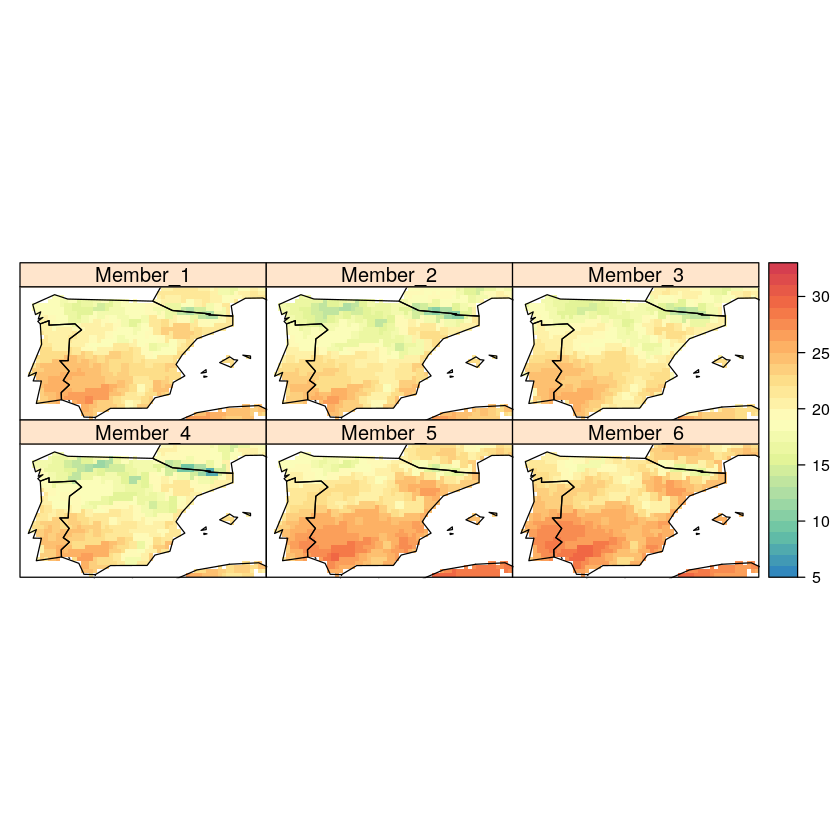

In [15]:
spatialPlot(climatology(TXf.ens), at = seq(5, 33, 1), backdrop.theme = "countries",
            col.regions = colorRampPalette(colstx), layout = c(3, 2), as.table = TRUE)


In order to calculate the bias of each model with respect to the observations and generate Figure \ref{fig:fig8b} (Fig. 8(below) in the manuscript) we apply function `aggregateGrid`, `gridArithmetics`, `bindGrid` and `spatialPlot` as follows:


In [16]:
# Create a multimember grid
TXh.list.ann <- lapply(TXh.list, function(x) 
  aggregateGrid(x, aggr.y = list(FUN = "mean", na.rm = TRUE)))
TX.ann <- aggregateGrid(TX, aggr.y = list(FUN = "mean", na.rm = TRUE))
TXh.list.bias <- lapply(TXh.list.ann, function(x) 
  gridArithmetics(x, TX.ann, operator = "-"))

[2018-12-14 12:55:44] Performing annual aggregation...
[2018-12-14 12:55:45] Done.
[2018-12-14 12:55:45] Performing annual aggregation...
[2018-12-14 12:55:45] Done.
[2018-12-14 12:55:45] Performing annual aggregation...
[2018-12-14 12:55:46] Done.
[2018-12-14 12:55:46] Performing annual aggregation...
[2018-12-14 12:55:47] Done.
[2018-12-14 12:55:47] Performing annual aggregation...
[2018-12-14 12:55:48] Done.
[2018-12-14 12:55:48] Performing annual aggregation...
[2018-12-14 12:55:49] Done.
[2018-12-14 12:55:49] Performing annual aggregation...
[2018-12-14 12:55:50] Done.


In [17]:
tx_iberia.ann <- NULL
txHist_iberia.ann <- NULL

In [18]:
TXh.bias.ens <- bindGrid(TXh.list.bias, dimension = "member")

[2018-12-14 12:55:50] - Computing climatology...
[2018-12-14 12:55:50] - Done.


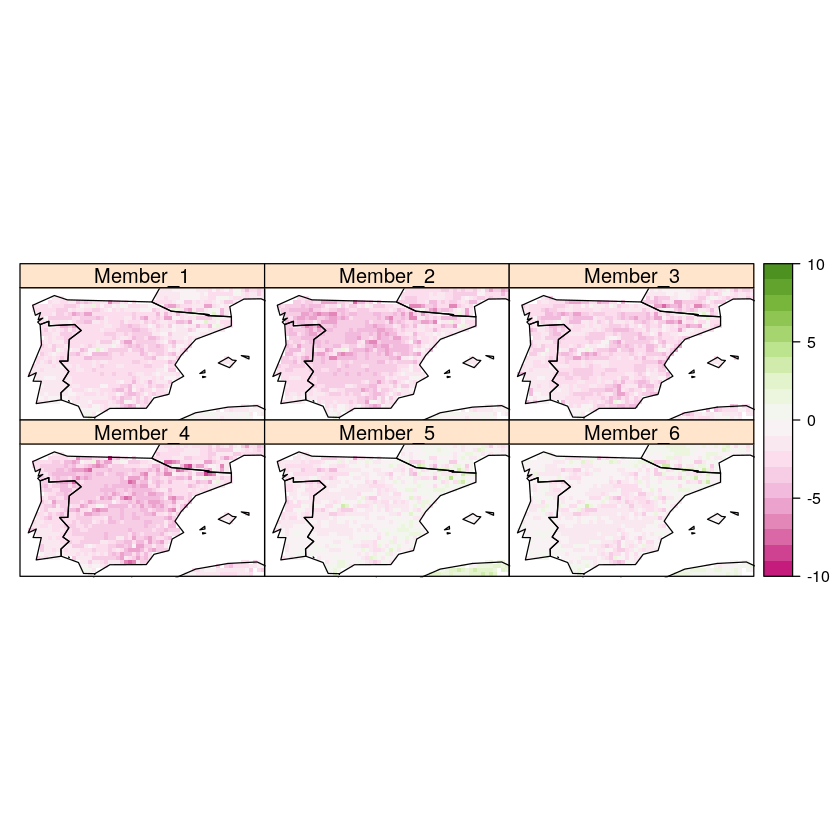

In [19]:
spatialPlot(climatology(TXh.bias.ens), at = seq(-10, 10, 1), backdrop.theme = "countries",
            col.regions = colorRampPalette(colsbias), layout = c(3, 2), as.table = TRUE)


We can use function `aggregateGrid` to for example calculate the multi-member mean and deviation of the ensemble. In this case, we previously compute the mean climatology so that the posterior aggregation is computationally less demanding:


In [20]:
TXf.ens.mean <- aggregateGrid(climatology(TXf.ens), aggr.mem = list(FUN = mean, na.rm = TRUE))
TXf.ens.sd <- aggregateGrid(climatology(TXf.ens), aggr.mem = list(FUN = sd, na.rm = TRUE))

[2018-12-14 12:56:04] - Computing climatology...
[2018-12-14 12:56:07] - Done.
[2018-12-14 12:56:08] - Aggregating members...
[2018-12-14 12:56:08] - Done.
[2018-12-14 12:56:12] - Computing climatology...
[2018-12-14 12:56:16] - Done.
[2018-12-14 12:56:16] - Aggregating members...
[2018-12-14 12:56:16] - Done.


Next we generate the corresponding Figures \ref{fig:fig8c} and \ref{fig:fig8d} (Not shown in the manuscript).


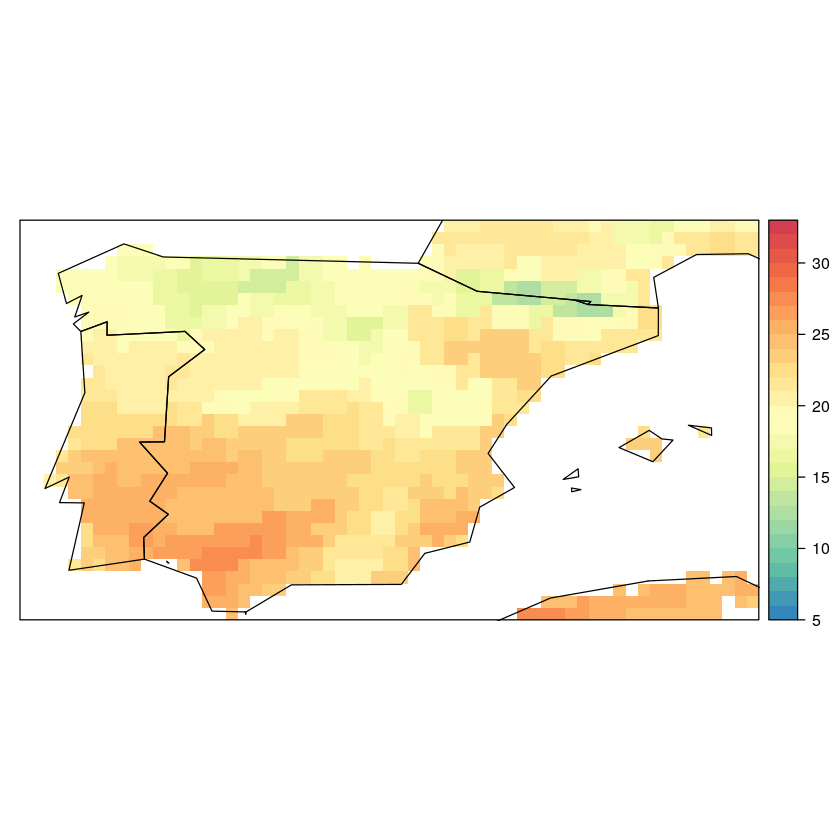

In [21]:
spatialPlot(TXf.ens.mean, at = seq(5, 33, 1),
            col.regions = colorRampPalette(colstx), backdrop.theme = "countries")

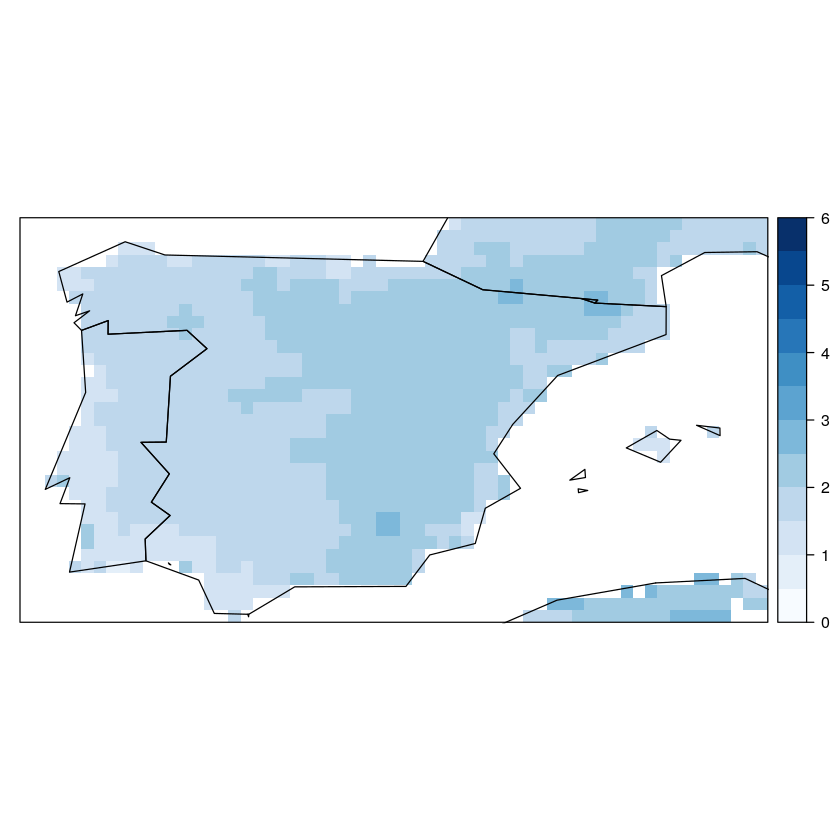

In [22]:
spatialPlot(TXf.ens.sd, at = seq(0, 6, .5),
            col.regions = colorRampPalette(colssd), backdrop.theme = "countries")

## ETCCDI index calculation (SU) from raw data

Next the raw SU index (summer days) is calculated for the whole ensemble and future period 2071-2100 (object `SUf.ens`), in a single line with function `climdexGrid`:


In [23]:
SUf.ens <- climdexGrid(tx = TXf.ens, index.code = "SU")

[2018-12-14 12:56:22] Calculating SU ...
[2018-12-14 12:58:34] Done


We calculate the ensemble mean and deviation using function `aggregateGrid`. We previously compute the mean climatology so that the posterior aggregation is computationally less demanding:


In [24]:
SUf.ens.mean <- aggregateGrid(climatology(SUf.ens), aggr.mem = list(FUN = mean, na.rm = TRUE))
SUf.ens.sd <- aggregateGrid(climatology(SUf.ens), aggr.mem = list(FUN = sd, na.rm = TRUE))

[2018-12-14 12:58:34] - Computing climatology...
[2018-12-14 12:58:34] - Done.
[2018-12-14 12:58:34] - Aggregating members...
[2018-12-14 12:58:34] - Done.
[2018-12-14 12:58:34] - Computing climatology...
[2018-12-14 12:58:34] - Done.
[2018-12-14 12:58:34] - Aggregating members...
[2018-12-14 12:58:35] - Done.


And finally, we plot the results to generate Figures \ref{fig:fig6top1} and \ref{fig:fig6top2} (Figs. 6(top, left) and 6(top, right) in the manuscript:


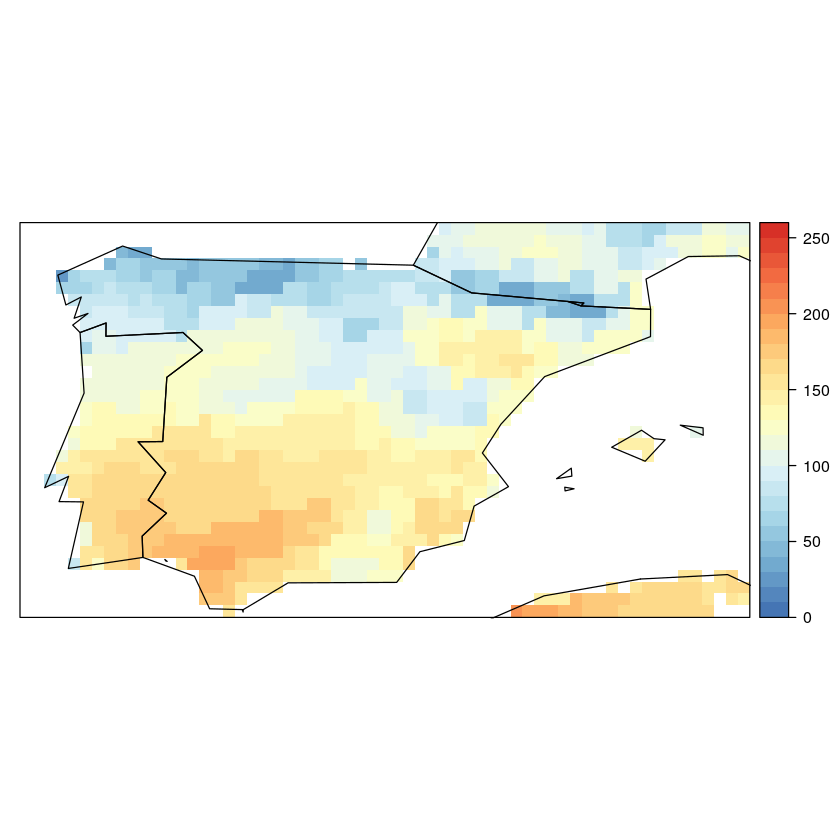

In [25]:
spatialPlot(SUf.ens.mean, backdrop.theme = "countries", 
            at = seq(0, 260, 10), col.regions = colorRampPalette(colsindex))

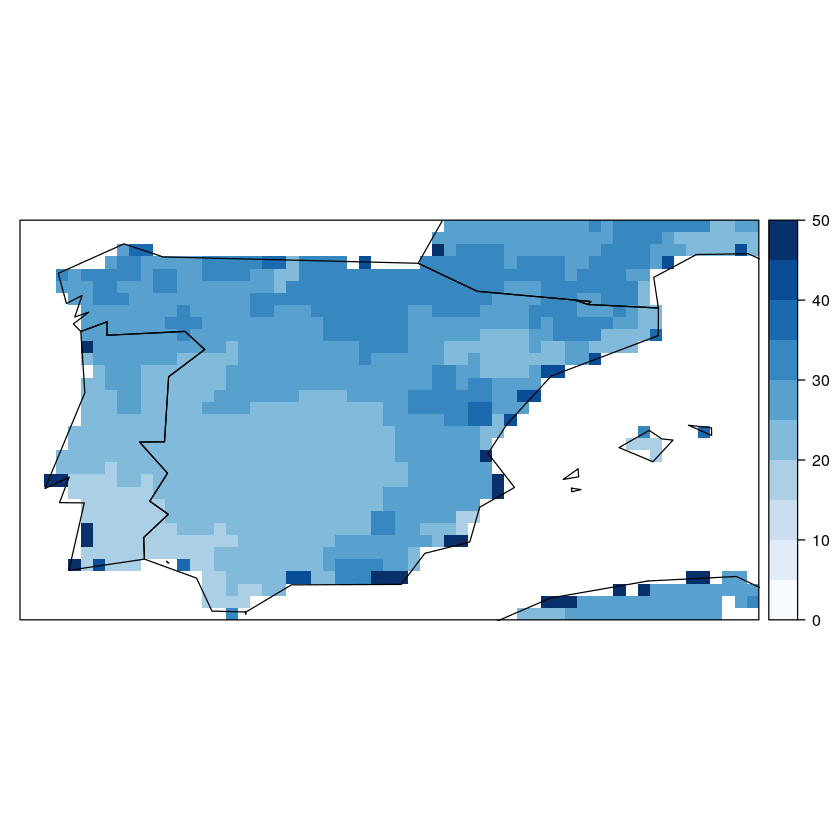

In [26]:
spatialPlot(SUf.ens.sd, set.max = 50, backdrop.theme = "countries", 
            at = seq(0, 50, 5), col.regions = colorRampPalette(colssd))

## Bias correction of the maximum temperature

Here we apply Empirical Quantile Mapping (EQM) for correcting the bias of each ensemble member (by default argument `join.members = FALSE`) by considering a moving correction window of 30 days to correct each 7-day time interval (note that this can take several minutes, see the execution timeline below):


In [27]:
TXf.ens.bc <- biasCorrection(TX, 
                              TXh.ens, 
                              TXf.ens, 
                              window = c(30, 7), 
                              extrapolation = "constant",
                              method = "eqm")

[2018-12-14 12:59:01] Argument precipitation is set as FALSE, please ensure that this matches your data.
[2018-12-14 12:59:24] Number of windows considered: 51...
[2018-12-14 12:59:24] Bias-correcting 6 members separately...
[2018-12-14 13:14:32] Done.


As done before, we calculate the ensemble mean and deviation of the maximum temperature with function `aggregateGrid`. We previously compute the mean climatology so that the posterior aggregation is computationally less demanding:


In [28]:
TXf.ens.bc.mean <- aggregateGrid(climatology(TXf.ens.bc), aggr.mem = list(FUN = mean, na.rm = TRUE))
TXf.ens.bc.sd <- aggregateGrid(climatology(TXf.ens.bc), aggr.mem = list(FUN = sd, na.rm = TRUE))

[2018-12-14 13:14:33] - Computing climatology...
[2018-12-14 13:14:38] - Done.
[2018-12-14 13:14:38] - Aggregating members...
[2018-12-14 13:14:38] - Done.
[2018-12-14 13:14:40] - Computing climatology...
[2018-12-14 13:14:55] - Done.
[2018-12-14 13:14:55] - Aggregating members...
[2018-12-14 13:14:56] - Done.


We plot the results to generate Figures \ref{fig:fig8e} and \ref{fig:fig8f} (Not shown in the manuscript):


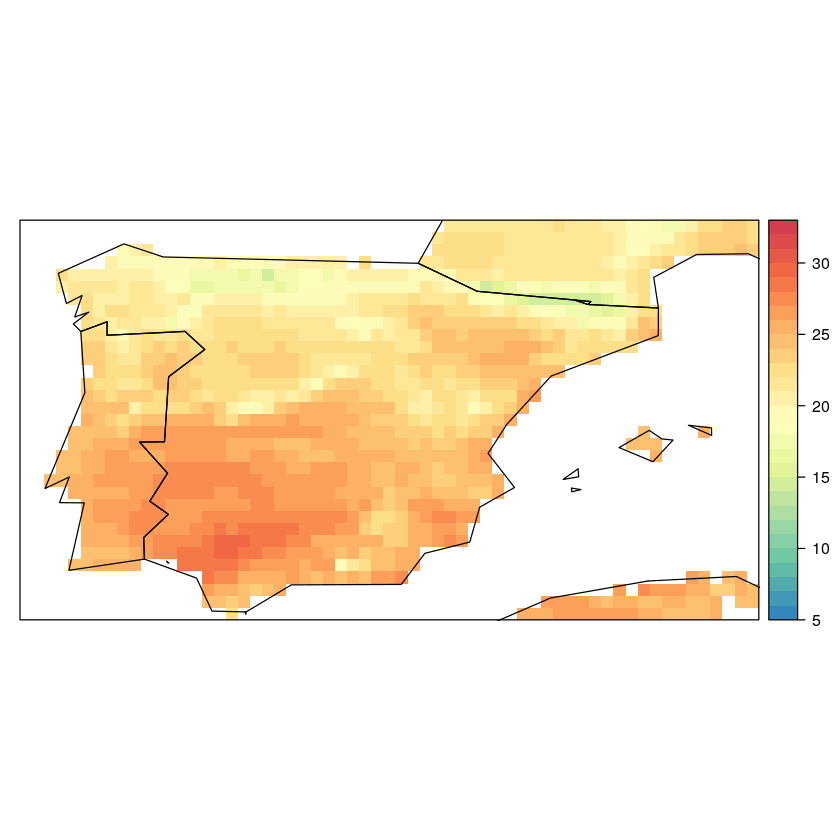

In [29]:
spatialPlot(TXf.ens.bc.mean, backdrop.theme = "countries", 
            at = seq(5, 33, 1), col.regions = colorRampPalette(colstx))

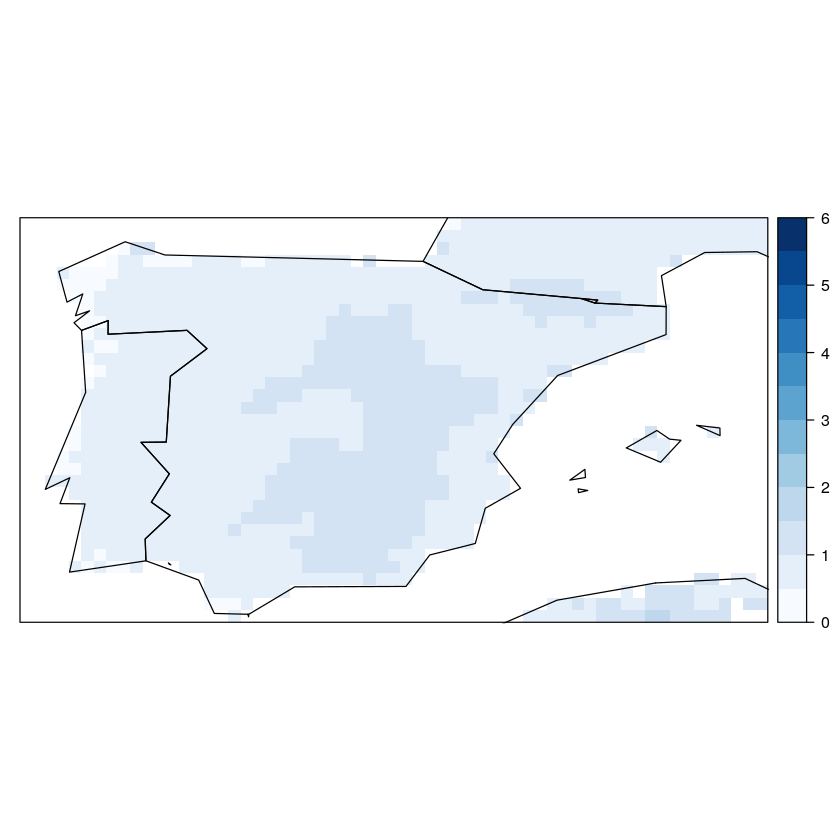

In [30]:
spatialPlot(TXf.ens.bc.sd, backdrop.theme = "countries", 
            at = seq(0, 6, .5), col.regions = colorRampPalette(colssd))

## ETCCDI index calculation (SU) from bias corrected data

Next we apply function `climdexGrid` over the bias corrected maximum temperature (object `TXf.ens.bc`) to obtain the corrected SU index for the future period.


In [31]:
SUf.ens.bc <- climdexGrid(tx = TXf.ens.bc, index.code = "SU")

[2018-12-14 13:15:02] Calculating SU ...
[2018-12-14 13:17:16] Done


Again, the ensemble mean and deviation is calculated:


In [32]:
SUf.ens.bc.mean <- aggregateGrid(SUf.ens.bc, aggr.mem = list(FUN = mean, na.rm = TRUE))
SUf.ens.bc.sd <- aggregateGrid(SUf.ens.bc, aggr.mem = list(FUN = sd, na.rm = TRUE))

[2018-12-14 13:17:16] - Aggregating members...
[2018-12-14 13:17:16] - Done.
[2018-12-14 13:17:16] - Aggregating members...
[2018-12-14 13:17:18] - Done.


By plotting these results Figures \ref{fig:fig6below1} and \ref{fig:fig6below2} are generated (Figs. 6(below, left) and 6(below, right) in the manuscript):


[2018-12-14 13:17:18] - Computing climatology...
[2018-12-14 13:17:18] - Done.


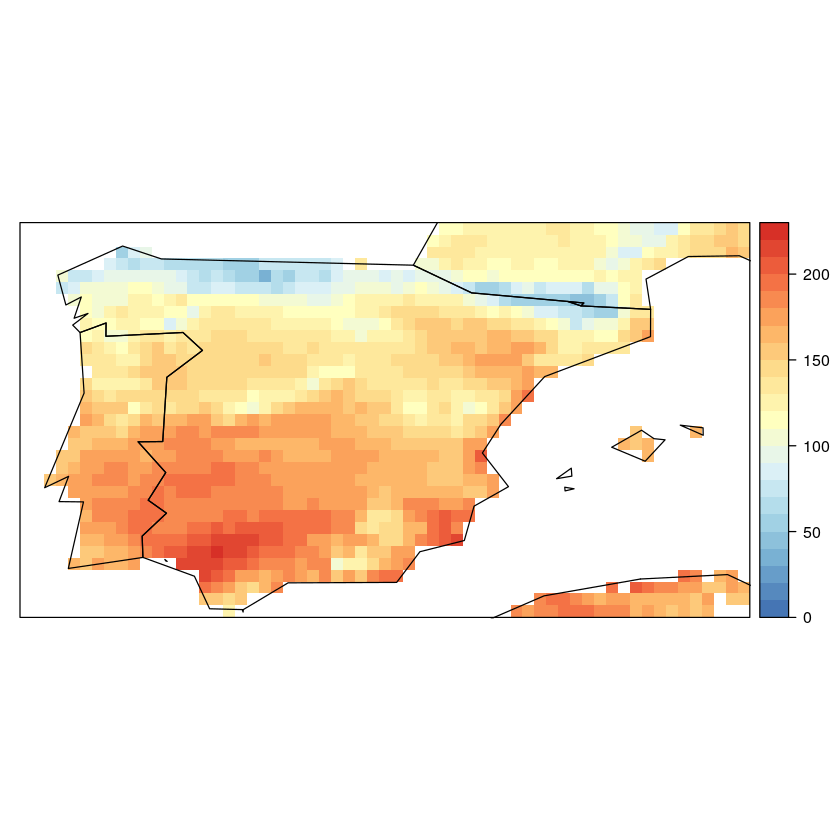

In [33]:
spatialPlot(climatology(SUf.ens.bc.mean), backdrop.theme = "countries", 
            at = seq(0, 230, 10), col.regions = colorRampPalette(colsindex))

[2018-12-14 13:17:21] - Computing climatology...
[2018-12-14 13:17:21] - Done.


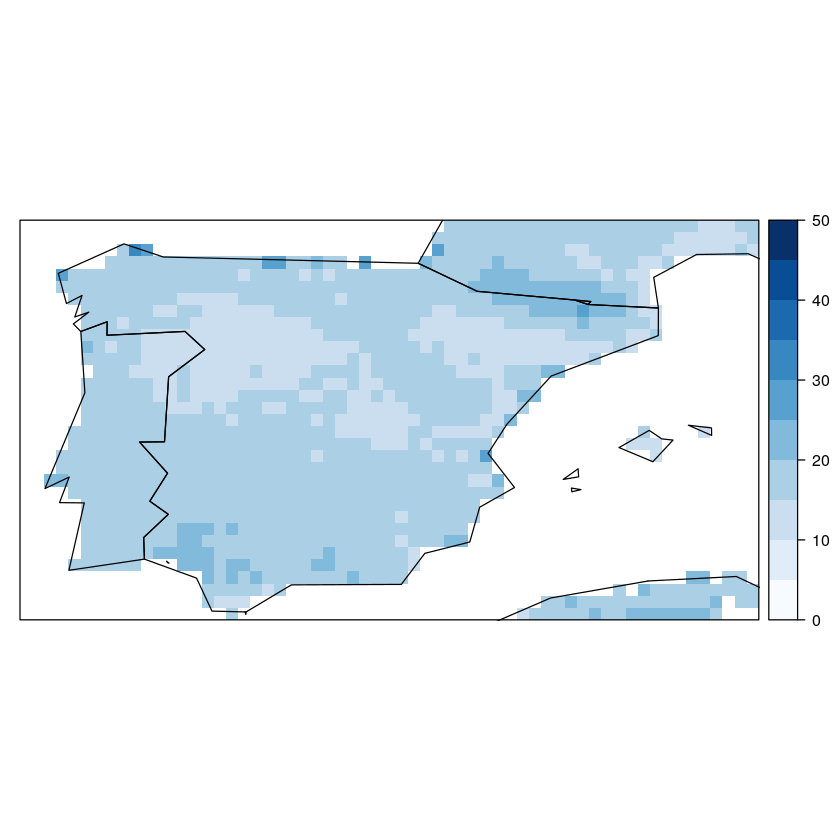

In [34]:
spatialPlot(climatology(SUf.ens.bc.sd), backdrop.theme = "countries", 
            at = seq(0, 50, 5), col.regions = colorRampPalette(colssd))

In order to generate Figure \ref{fig:fig7} (Fig. 7 in the manuscript), we next calculate the SU index from observational data (`SU`) and the historical model ensemble (`SUh.ens`):


In [35]:
#A single location
SU <- climdexGrid(tx = TX, index.code = "SU")
SUh.ens <- climdexGrid(tx = TXh.ens, index.code = "SU")

[2018-12-14 13:17:24] Calculating SU ...
[2018-12-14 13:17:48] Done
[2018-12-14 13:17:54] Calculating SU ...
[2018-12-14 13:20:08] Done


For visualization purposes, the 1rst memeber of CORDEX data is extracted and everything (E-OBS, the ensemble of CORDEX, and the 1st member of CORDEX) is listed in object `SU.Z` for plotting:


In [36]:
SU.Z.cdx <- list(SUh.ens, SUf.ens, SUf.ens.bc)
SU.Z.1m <- lapply(SU.Z.cdx, function(x)
                        subsetGrid(x, members = 1))
SU.Z <- c(list(SU), SU.Z.cdx, SU.Z.1m)

Finally `temporalPlot` is used to generate Figure  \ref{fig:fig7} (Fig. 7 in the manuscript). The nearest point to Zaragoza (Spain) is selected via arguments `latLim` and `lonLim`:


pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year


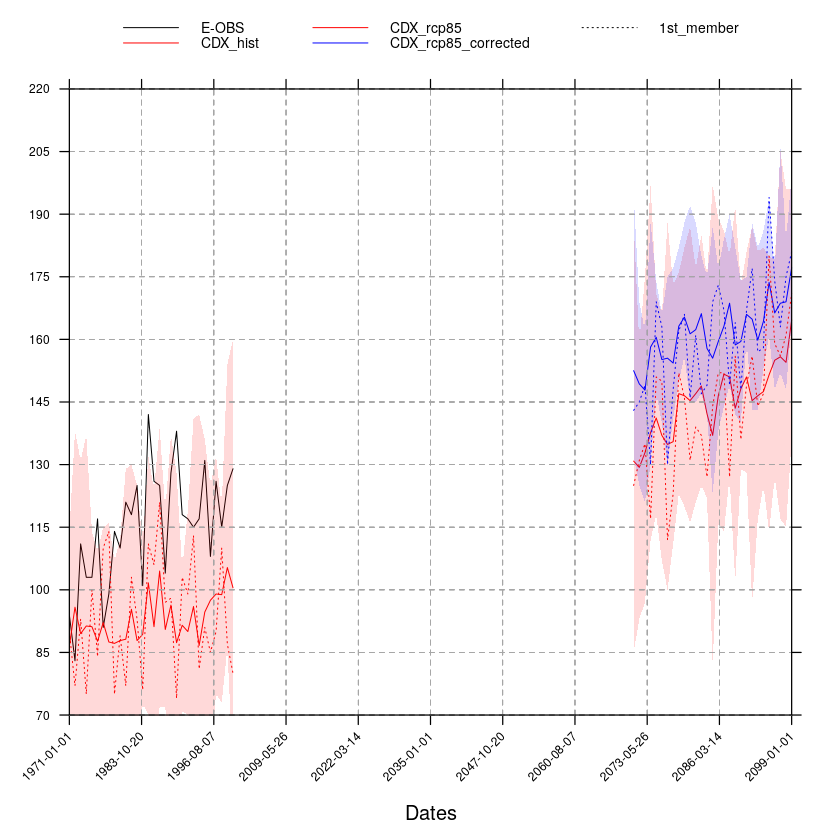

In [37]:
cols  <- c("black", rep(c("red", "red", "blue"), 2))
temporalPlot(SU.Z,
             latLim = 41.64, 
             lonLim = -0.89,
             cols = cols,
             lty = rep(c(1,3), each = 4),
             lwd = 0.8,
             xyplot.custom = 
               list(ylim = c(70, 220), ylab = "",
                                  key = list(space = "top", 
                                             lines = list(lty = c(rep(1,4), 3), 
                                                          col = c(cols[1:4], cols[1]),
                                                          lwd = 0.8), 
                                             text = list(c("E-OBS", "CDX_hist", 
                                                    "CDX_rcp85", "CDX_rcp85_corrected",
                                                           "1st_member"),
                                                         cex = .7), 
                                             columns = 3, rows = 3)))

In [38]:
rm(list=c("SU.Z", "SU","SUh.ens","SU.Z.cdx","SU.Z.1m","SUf.ens.bc.mean","TXh.ens","TXf.ens","TXf.ens.bc"))

Warning message in rm(list = c("SU.Z", "SU", "SUh.ens", "SU.Z.eobs", "SU.Z.cdx", :
“object 'SU.Z.eobs' not found”

## Calculation of the ETCCDI index CDD (Consecutive Dry Days)

This section replicates the procedures shown top but for calculating a precipitation based index, i.e. CDD (consecutive dry days). Function `climdexShow` displays an overview of the available ETCDDI indices:


In [39]:
climdexShow()[,1:6]

      code                                           longname        indexfun
1       FD                               Number_of_frost_days      climdex.fd
2       SU                              Number_of_summer_days      climdex.su
3       ID                               Number_of_icing_days      climdex.id
4       TR                          Number_of_tropical_nights      climdex.tr
5      GSL                              Growing_season_length     climdex.gsl
6      TXx Monthly_maximum_value_of_daily_maximum_temperature     climdex.txx
7      TNx Monthly_maximum_value_of_daily_minimum_temperature     climdex.tnx
8      TXn Monthly_minimum_value_of_daily_maximum_temperature     climdex.txn
9      TNn Monthly_minimum_value_of_daily_minimum_temperature     climdex.tnn
10   TN10p         Percentage_of_days_when_TN<10th_percentile   climdex.tn10p
11   TX10p         Percentage_of_days_when_TX<10th_percentile   climdex.tx10p
12   TN90p         Percentage_of_days_when_TN>90th_percentile   

code,longname,indexfun,tn,tx,pr
FD,Number_of_frost_days,climdex.fd,1,0,0
SU,Number_of_summer_days,climdex.su,0,1,0
ID,Number_of_icing_days,climdex.id,0,1,0
TR,Number_of_tropical_nights,climdex.tr,1,0,0
GSL,Growing_season_length,climdex.gsl,1,1,0
TXx,Monthly_maximum_value_of_daily_maximum_temperature,climdex.txx,0,1,0
TNx,Monthly_maximum_value_of_daily_minimum_temperature,climdex.tnx,1,0,0
TXn,Monthly_minimum_value_of_daily_maximum_temperature,climdex.txn,0,1,0
TNn,Monthly_minimum_value_of_daily_minimum_temperature,climdex.tnn,1,0,0
TN10p,Percentage_of_days_when_TN<10th_percentile,climdex.tn10p,1,0,0


### Data loading and multi-member ensemble building

In order to calculate the CDD index, we need to load daily precipitation data. Therefore, we repeat the loading operation (function `loadGridData`) shown in the previous section (this time `var = "pr"`) for observational data (E-OBS) and historical and RCP8.5 projection data (6 models from CORDEX).


In [40]:
eobs.pr<-"http://opendap.knmi.nl/knmi/thredds/dodsC/e-obs_0.25regular/rr_0.25deg_reg_v16.0.nc"

In [41]:
write(c("identifier,short_name,time_step,lower_time_bound,upper_time_bound,cell_method,offset,scale,deaccum,derived,interface",
             "tasmax,tx,24h,0,24,max,0,1,0,0,",
        "pr,rr,24h,0,24,max,0,1,0,0,"), "dicEOBS.dic")

In [42]:
pr <- loadGridData(eobs,
                         var = "pr",
                         season = 1:12,
                         lonLim = lon,
                         latLim = lat,
                         years = 1971:2000)

NOTE: Accessing harmonized data from a public UDG dataset
[2018-12-14 13:20:09] Defining harmonization parameters for variable "pr"
[2018-12-14 13:20:09] Opening dataset...
[2018-12-14 13:20:10] The dataset was successfuly opened
[2018-12-14 13:20:10] Defining geo-location parameters
[2018-12-14 13:20:10] Defining time selection parameters
[2018-12-14 13:20:10] Retrieving data subset ...
[2018-12-14 13:20:41] Done


In [43]:
write(c("identifier,short_name,time_step,lower_time_bound,upper_time_bound,cell_method,offset,scale,deaccum,derived,interface",
             "tasmax,tasmax,24h,0,24,max,-273.15,1,0,0,",
             "pr,pr,24h,0,24,max,0,86400,0,0,"), "dicCDX.dic")

In [44]:
prh <- lapply(ensemble.h, function(x) 
                              loadGridData(dataset = x,
                              var = "pr",
                              season = 1:12,
                              lonLim = lon,
                              latLim = lat,
                              years = 1971:2000))
prf <- lapply(ensemble.f, function(x) 
                          loadGridData(dataset = x,
                          var = "pr",
                          season = 1:12,
                          lonLim = lon,
                          latLim = lat,
                          years = 2071:2100))
prh.t <- intersectGrid(prh, type = "temporal", which.return = 1:6)
prf.t <- intersectGrid(prf, type = "temporal", which.return = 1:6)
prh.ens <- bindGrid(prh.t, dimension = "member")
prf.ens <- bindGrid(prf.t, dimension = "member")

NOTE: Accessing harmonized data from a public UDG dataset
[2018-12-14 13:20:41] Defining harmonization parameters for variable "pr"
[2018-12-14 13:20:41] Opening dataset...
[2018-12-14 13:20:41] The dataset was successfuly opened
[2018-12-14 13:20:41] Defining geo-location parameters
[2018-12-14 13:20:41] Defining time selection parameters
[2018-12-14 13:20:41] Retrieving data subset ...
[2018-12-14 13:20:54] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2018-12-14 13:20:54] Defining harmonization parameters for variable "pr"
[2018-12-14 13:20:54] Opening dataset...
[2018-12-14 13:20:54] The dataset was successfuly opened
[2018-12-14 13:20:54] Defining geo-location parameters
[2018-12-14 13:20:54] Defining time selection parameters
[2018-12-14 13:20:54] Retrieving data subset ...
[2018-12-14 13:21:08] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2018-12-14 13:21:08] Defining harmonization parameters for variable "pr"
[2018-12-14 13:21:08] Opening da

Next the CDD index is calculated (function `climdexGrid`), and regridded (function `interpGrid`) to the spatial structure given by the observational data (`getGrid(pr)`). Then, the ensemble mean (object `CDDf.ens.mean`) and deviation (object `CDDf.ens.sd`) are calculated with `aggregateGrid`.


In [45]:
CDDf.ens <- climdexGrid(pr = prf.ens, index.code = "CDD")
CDDf.ens.interp <- interpGrid(CDDf.ens, getGrid(pr))
CDDf.ens.mean <- aggregateGrid(CDDf.ens.interp, 
                               aggr.mem = list(FUN = "mean", na.rm = TRUE))
CDDf.ens.sd <- aggregateGrid(CDDf.ens.interp, 
                             aggr.mem = list(FUN = "sd", na.rm = TRUE))

[2018-12-14 13:23:57] Calculating CDD ...
[2018-12-14 13:25:36] Done
NOTE: argument 'bilin.method' ignored for nearest neighbour interpolation
[2018-12-14 13:25:36] Calculating nearest neighbors...
[2018-12-14 13:25:36] Performing nearest interpolation... may take a while
[2018-12-14 13:25:36] Interpolating member 1 out of 6
[2018-12-14 13:25:36] Interpolating member 2 out of 6
[2018-12-14 13:25:36] Interpolating member 3 out of 6
[2018-12-14 13:25:36] Interpolating member 4 out of 6
[2018-12-14 13:25:36] Interpolating member 5 out of 6
[2018-12-14 13:25:36] Interpolating member 6 out of 6
[2018-12-14 13:25:36] Done
[2018-12-14 13:25:36] - Aggregating members...
[2018-12-14 13:25:37] - Done.
[2018-12-14 13:25:37] - Aggregating members...
[2018-12-14 13:25:39] - Done.


We also create and apply the land-sea mask:


In [46]:
m <- pr$Data[1,,]*0
mask.cdd <- array(dim = c(getShape(CDDf.ens.mean)["time"], dim(m)))
for (i in 1:dim(mask.cdd)[1]) mask.cdd[i,,] <- m 
CDDf.ens.mean <- gridArithmetics(CDDf.ens.mean, mask.cdd, operator = "+")
CDDf.ens.sd <- gridArithmetics(CDDf.ens.sd, mask.cdd, operator = "+")

Finally, we plot the result with function `spatialPlot` to generate Figures \ref{fig:fig9} and \ref{fig:fig10} (not shown in the manuscript).


[2018-12-14 13:25:39] - Computing climatology...
[2018-12-14 13:25:39] - Done.


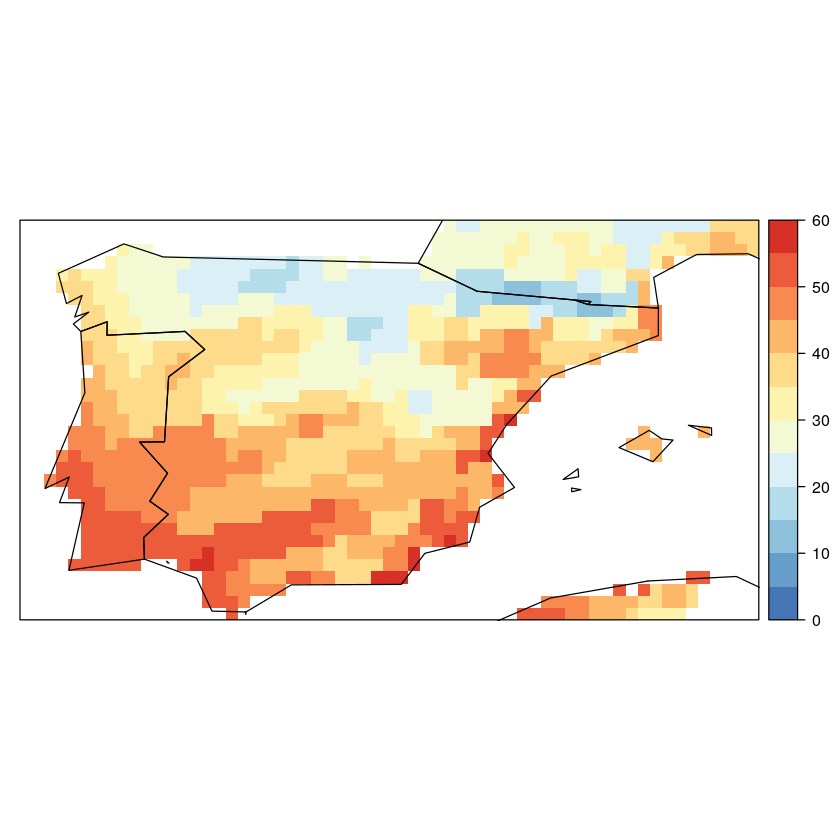

In [47]:
spatialPlot(climatology(CDDf.ens.mean), backdrop.theme = "countries", at = seq(0, 60, 5), 
            col.regions = colorRampPalette(colsindex))

[2018-12-14 13:25:41] - Computing climatology...
[2018-12-14 13:25:41] - Done.


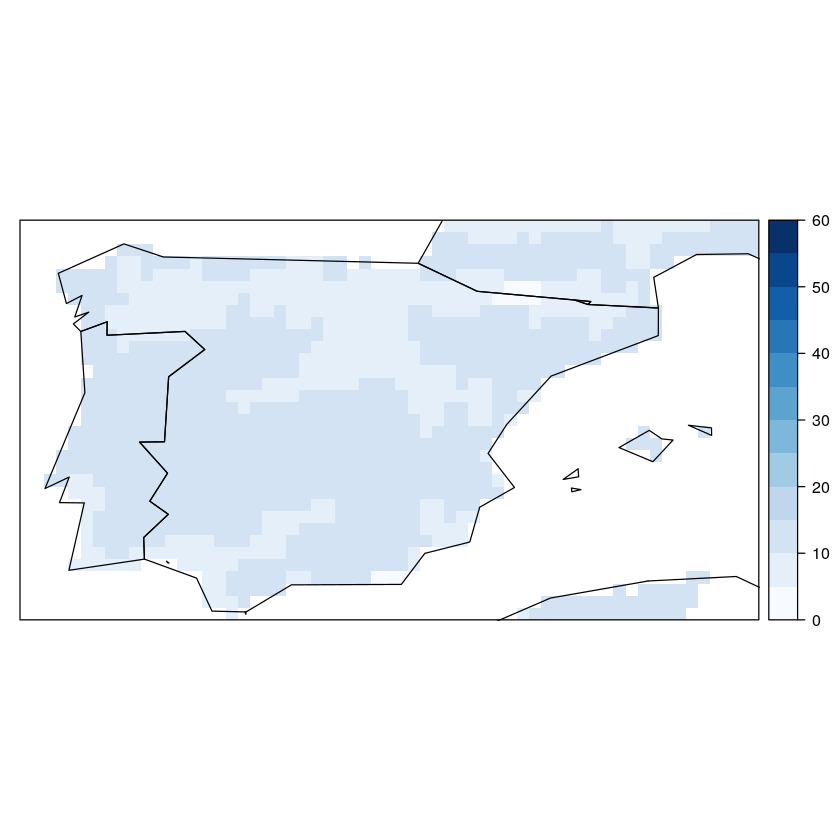

In [48]:
spatialPlot(climatology(CDDf.ens.sd), backdrop.theme = "countries", at = seq(0, 60, 5), 
            col.regions = colorRampPalette(colssd))


### Bias correction of the precipitation

Here, we use again the EQM method for bias correcting precipitation data to subsequently calculate the corrected CDD index (objects `CDDf.ens.bc`, `CDDf.ens.bc.mean`, `CDDf.ens.bc.sd`)(note that this can take several minutes, see the execution timeline below).


In [49]:
prf.ens.bc <- biasCorrection(y = pr, 
                                    x = prh.ens, 
                                    newdata = prf.ens,
                                    precipitation = TRUE,
                                    window = c(30, 7), 
                                    extrapolation = "constant",
                                    method = "eqm",
                                    wet.threshold = 0.1)
CDDf.ens.bc <- climdexGrid(pr = prf.ens.bc, index.code = "CDD")
CDDf.ens.bc.mean <- aggregateGrid(CDDf.ens.bc, 
                                  aggr.mem = list(FUN = "mean", na.rm = TRUE))
CDDf.ens.bc.sd <- aggregateGrid(CDDf.ens.bc, 
                                aggr.mem = list(FUN = "sd", na.rm = TRUE))

[2018-12-14 13:26:21] Argument precipitation is set as TRUE, please ensure that this matches your data.
[2018-12-14 13:26:35] Number of windows considered: 51...
[2018-12-14 13:26:36] Bias-correcting 6 members separately...
[2018-12-14 14:03:40] Done.
[2018-12-14 14:03:41] Calculating CDD ...
[2018-12-14 14:05:58] Done
[2018-12-14 14:05:58] - Aggregating members...
[2018-12-14 14:05:58] - Done.
[2018-12-14 14:05:58] - Aggregating members...
[2018-12-14 14:06:00] - Done.


This results are plotted to generate Figures \ref{fig:fig11} and \ref{fig:fig12} (not shown in the manuscript):


[2018-12-14 14:06:00] - Computing climatology...
[2018-12-14 14:06:00] - Done.


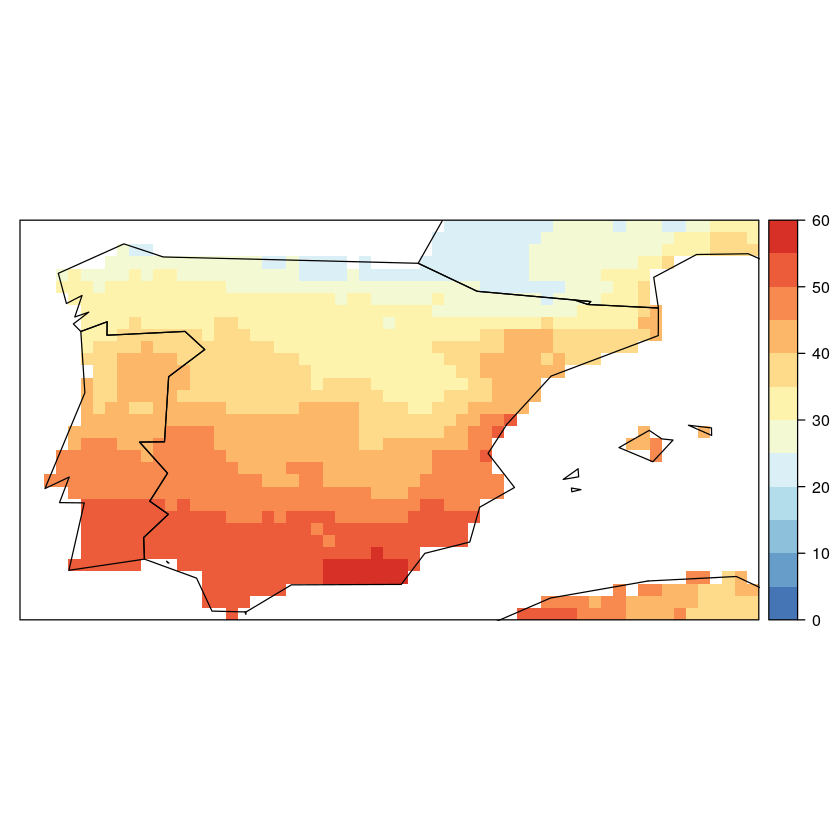

In [50]:
spatialPlot(climatology(CDDf.ens.bc.mean), backdrop.theme = "countries", 
            at = seq(0, 60, 5), col.regions = colorRampPalette(colsindex))

[2018-12-14 14:06:02] - Computing climatology...
[2018-12-14 14:06:02] - Done.


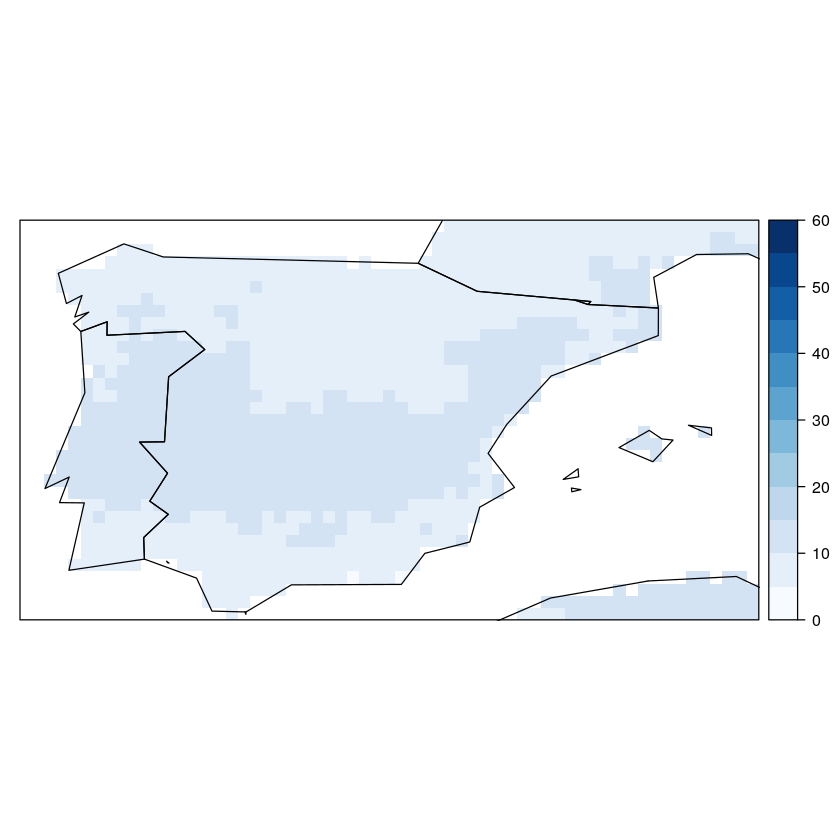

In [51]:
spatialPlot(climatology(CDDf.ens.bc.sd), backdrop.theme = "countries", 
            at = seq(0, 60, 5), col.regions = colorRampPalette(colssd))

In this case, unlike the SU index, the uncertainty is not reduced before and after bias correcting the original variable (compare Figs. \ref{fig:fig10} and \ref{fig:fig12}). Nevertheless the pattern of the index is significantly modified (compare Figs. \ref{fig:fig9} and \ref{fig:fig11}).

# Other available material

* [2018_climate4R_example1.pdf](https://github.com/SantanderMetGroup/notebooks/blob/devel/2018_climate4R_example1.pdf) contains the full code for **Example 1** of the paper `climate4R: An Ecosystem of R packages for Climate Data Access, Post-processing and Bias Correction'.
* Find more worked examples on the utilization of climate4R packages in their respective GitHub **wiki**-s at [https://github.com/SantanderMetGroup](https://github.com/SantanderMetGroup):
    + [loadeR: https://github.com/SantanderMetGroup/loadeR/wiki](https://github.com/SantanderMetGroup/loadeR/wiki)
    + [transformeR: https://github.com/SantanderMetGroup/transformeR/wiki](https://github.com/SantanderMetGroup/transformeR/wiki)
    + [downscaleR: https://github.com/SantanderMetGroup/downscaleR/wiki](https://github.com/SantanderMetGroup/downscaleR/wiki)
    + [visualizeR: https://github.com/SantanderMetGroup/visualizeR/wiki](https://github.com/SantanderMetGroup/visualizeR/wiki) 
